# LIGO noise curve

This notebook will show how to plot a LIGO noise curve, and how noise can hide parts of a signal.

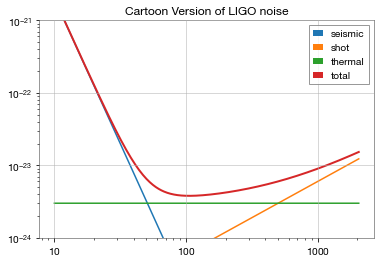

In [61]:
import matplotlib.pyplot as plt
import numpy as np
from gwpy.timeseries import TimeSeries
%matplotlib inline

# -- Define an array or frequencies
freqs = np.arange(10,2048)

# -- Make a cartoon model of LIGO noise
seismic = 2e-17*(1/freqs**4)
brownian = 3e-24*np.ones(len(freqs))
shot = 6e-27*(freqs)
cartoon_asd = seismic+shot+brownian

# -- Plot the model
plt.loglog(freqs, seismic, label='seismic')
plt.loglog(freqs, shot, label='shot')
plt.loglog(freqs, brownian, label='thermal')
plt.loglog(freqs, cartoon_asd, linewidth=2, label='total')
plt.ylim(1e-24, 1e-21)
plt.title('Cartoon Version of LIGO noise')
plt.legend()

(1e-24, 1e-20)

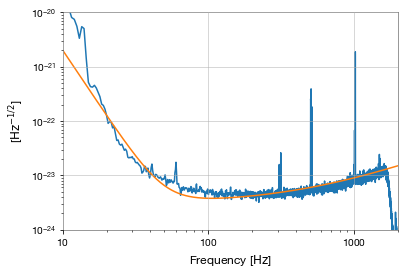

In [62]:

# -- Get some data from O3
t0 = 1249852257.0
strain = TimeSeries.fetch_open_data('L1', t0-14, t0+14, cache=False)

# -- Plot the ASD, along with the cartoon model
asd = strain.asd(fftlength=2)
asd.plot()
plt.xlim(10,2000)
plt.loglog(freqs, cartoon_asd)
plt.ylim(1e-24, 1e-20)